In [1]:
require(data.table)
require(tidyverse)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(RColorBrewer)
require(metacoder)
require(vegan)
require(DESeq2)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second(

In [2]:
#load sample metadata skipping first row
samdt=fread("/home/caroline_desouza_uml_edu/2_randomized_immune_metagenomics_PCR.csv", header=TRUE)
#load csv files after removing chimeras
asv_all=fread("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_ASV_nochim.csv")
taxa=read.csv(file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_taxa.csv", header=TRUE, row.names=1)

In [3]:
head(samdt)
class(asv_all)

V1,Tubelabel_species,Health_Status,Date_Extracted,Raw_ng_ul,Extraction_physical_location,Date_Enriched,Microbe_Location,colony,Date_16S,Date_ITS2,16S double band
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,052022_BEL_CBC_T1_2_SSID,Healthy,12_2_2024,7.73,"UML_NARWHAL_R2_B14, UML_NARWHAL_R2_B33",,,1_3,1_22_2025,6_26_2025,
2,092023_BEL_CBC_T1_175_PAST,Healthy,1_15_2025,2.3,UML_NARWHAL_R2_B15,,,1_13,1_22_2025,6_26_2025,y
4,022024_BEL_CBC_T3_851_PSTR,Healthy,11_26_2024,64.2,UML_NARWHAL_R2_B13,,,3_70,1_23_2025,6_26_2025,
5,082024_BEL_CBC_T4_1609_OFAV,Healthy,1_15_2025,61.2,UML_NARWHAL_R2_B15,,,4_78,1_23_2025,6_26_2025,y
6,122023_BEL_CBC_T3_526_SSID,Healthy,11_19_2024,16.4,UML_NARWHAL_R2_B13,,,3_5,1_23_2025,6_26_2025,
7,112023_BEL_CBC_T4_399_MCAV,Healthy,11_15_2024,13.9,UML_NARWHAL_R2_B12,,,4_76,1_23_2025,6_26_2025,


[1] "data.table" "data.frame"

In [4]:
#cleaning samdt
samdt <- samdt[samdt$Date_16S != 'NA', ]
# Create a new data frame with the species, date, and transect columns
# Example samdt (make sure your data is a data.table)
setDT(samdt)
# Split Tubelabel_species by "_" and assign new columns
samdt[, c("date", "transect", "species") := {
  parts <- strsplit(Tubelabel_species, "_")
  list(
    sapply(parts, `[`, 1),  # date is first element
    sapply(parts, `[`, 4),  # transect is 4th element
    sapply(parts, `[`, 6)   # species is 6th element
  )
}]
clean_samdt <- samdt[, c("Date_Extracted", "Raw_ng_ul", "Extraction_physical_location", "Date_Enriched", "Date_ITS2", "Microbe_Location") := NULL]

In [5]:
head(samdt)

V1,Tubelabel_species,Health_Status,colony,Date_16S,16S double band,date,transect,species
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,052022_BEL_CBC_T1_2_SSID,Healthy,1_3,1_22_2025,,052022,T1,SSID
2,092023_BEL_CBC_T1_175_PAST,Healthy,1_13,1_22_2025,y,092023,T1,PAST
4,022024_BEL_CBC_T3_851_PSTR,Healthy,3_70,1_23_2025,,022024,T3,PSTR
5,082024_BEL_CBC_T4_1609_OFAV,Healthy,4_78,1_23_2025,y,082024,T4,OFAV
6,122023_BEL_CBC_T3_526_SSID,Healthy,3_5,1_23_2025,,122023,T3,SSID
7,112023_BEL_CBC_T4_399_MCAV,Healthy,4_76,1_23_2025,,112023,T4,MCAV


In [6]:
samdt$V1 <- NULL             # Drop unwanted numeric ID column V1

In [7]:
head(samdt)

Tubelabel_species,Health_Status,colony,Date_16S,16S double band,date,transect,species
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
052022_BEL_CBC_T1_2_SSID,Healthy,1_3,1_22_2025,,052022,T1,SSID
092023_BEL_CBC_T1_175_PAST,Healthy,1_13,1_22_2025,y,092023,T1,PAST
022024_BEL_CBC_T3_851_PSTR,Healthy,3_70,1_23_2025,,022024,T3,PSTR
082024_BEL_CBC_T4_1609_OFAV,Healthy,4_78,1_23_2025,y,082024,T4,OFAV
122023_BEL_CBC_T3_526_SSID,Healthy,3_5,1_23_2025,,122023,T3,SSID
112023_BEL_CBC_T4_399_MCAV,Healthy,4_76,1_23_2025,,112023,T4,MCAV


In [8]:
#change format of tubelabel_species exactly match samdf 
# Extract and reformat filename to "Tubelabel_species"

# Step 1: Replace '-' with '_' in asv_all$V1
asv_all$V1 <- gsub("-", "_", asv_all$V1)

In [9]:
#fix asv_all rownames
rows=as.vector(asv_all[,1])
asv_all=asv_all[,-1]
asv_all=apply(asv_all, 2, as.numeric)
row.names(asv_all)=rows$V1

In [10]:
class(asv_all)

[1] "matrix" "array"

In [11]:
head(asv_all)

,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,TACGGGGGATGCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGGAGCGAATGGG,ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,TACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCGAACGGG,⋯,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATAGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCAAACAGGATTAGAAACCCGTGTAGTCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGAC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATAGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCAAACAGGATTAGATACCCTCGTAGTCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGAC,GCACGTAGGCGGCGCGGTAAGTCCATTGTGAAAGCCCTCGGCTCAACCGAGGAAGTGCAGTGGAAACTGCCGTGCTTGAGTACGGGAGAGGAGAGTGGAATTCCCGGTGAAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAAGCGGCTCTCTGGACCGTCACTGACGCTGAGGTGCGAAAGCTGGGGGAGCGAACGGGATTAGATACCCTAGTAGTCCCTGTCTCTTATACACATCTCC,GGGTGTCAGCAGCCGCGGTAATACGGAGGGTCCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTAGATCAGTCGGGTGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTCGATACTGTCTGACTGGAGTATGGGAGAGGGCAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAACACCTGTGGCGAAGGCGGCTGCCTGGCCCAATACTGACGCTGAGGTG,ATACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGCTGACCAAGTCAGAGGTGAAAGGCCCGGGCTCAACCTGGGAACTGCCTTTGAAACTGGTCGGCTCGAGTCCGGAAGAGGATAGCGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTATCTGGTCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

In [12]:
#optional to set rownames
samdf <- as.data.frame(samdt)              # Convert to data.frame (from data.table)
rownames(samdf) <- samdf$Tubelabel_species # Set rownames
samdf$Tubelabel_species <- NULL    
head(samdf)

,Health_Status,colony,Date_16S,16S double band,date,transect,species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
052022_BEL_CBC_T1_2_SSID,Healthy,1_3,1_22_2025,,052022,T1,SSID
092023_BEL_CBC_T1_175_PAST,Healthy,1_13,1_22_2025,y,092023,T1,PAST
022024_BEL_CBC_T3_851_PSTR,Healthy,3_70,1_23_2025,,022024,T3,PSTR
082024_BEL_CBC_T4_1609_OFAV,Healthy,4_78,1_23_2025,y,082024,T4,OFAV
122023_BEL_CBC_T3_526_SSID,Healthy,3_5,1_23_2025,,122023,T3,SSID
112023_BEL_CBC_T4_399_MCAV,Healthy,4_76,1_23_2025,,112023,T4,MCAV


In [13]:
# Find the shared rownames (in case one is a subset of the other)
common_samples <- intersect(rownames(samdf), rownames(asv_all))

# Reorder both objects to match the same order
samdf <- samdf[common_samples, , drop = FALSE]
asv_all <- asv_all[common_samples, , drop = FALSE]


In [14]:
#double check that all rownames match
all(rownames(asv_all) %in% rownames(samdf))  # Should be TRUE
all(rownames(samdf) %in% rownames(asv_all))  # Should be TRUE

[1] TRUE

[1] TRUE

In [15]:
# Reorder taxa to match asv_all
#Get common ASVs
common_asvs <- intersect(colnames(asv_all), rownames(taxa))

# Subset both
asv_all <- asv_all[, common_asvs]
taxa <- taxa[common_asvs, ]

In [16]:
sum(is.na(match(colnames(asv_all), rownames(taxa))))
identical(colnames(asv_all), rownames(taxa))  # Should be TRUE

[1] 0

[1] TRUE

Final checks before running through phyloseq

In [17]:
#check if asv_all is numeric
all(sapply(as.data.table(asv_all), is.numeric))

[1] TRUE

In [18]:
identical(colnames(asv_all), rownames(taxa))  # MUST be TRUE
identical(rownames(asv_all), rownames(samdf))  # MUST be TRUE

[1] TRUE

[1] TRUE

In [19]:
head(taxa)

,Kingdom,Phylum,Class,Order,Family,Genus
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,Bacteria,Pseudomonadota,Alphaproteobacteria,NA,NA,NA
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,Bacteria,Pseudomonadota,Alphaproteobacteria,NA,NA,NA
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Alphaproteobacteria,NA,NA,NA


In [20]:
#save .csv files
write.csv(asv_all, file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/asv_all.csv")
write.csv(samdf, file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/16S_metadata.csv")

two ways of using phyloseq??

In [21]:
# Convert asv_all to otu_table (specify taxa_are_rows = TRUE/FALSE depending on your data)
otu <- otu_table(asv_all, taxa_are_rows = FALSE)  # or TRUE if taxa in rows

# Sample metadata as sample_data
sampledata <- sample_data(samdf)

taxa=as.matrix(taxa)

taxa=tax_table(taxa)

# Construct phyloseq object
ps <- phyloseq(otu, sampledata, taxa)

In [22]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 95300 taxa and 95 samples ]
sample_data() Sample Data:       [ 95 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 95300 taxa by 6 taxonomic ranks ]

remove sample with less than 10K reads, but look at distribution 
getting rid of the ones that were size selected for nothing 

Should I prune taxa this early?

In [23]:
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

other way of using phyloseq?

OTU = otu_table((asv_all), taxa_are_rows = FALSE)
TAX = tax_table(taxa)
SAMP = sample_data(samdf)

In [24]:
head(taxa_names(ps))

[1] "TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG"  
[2] "ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA"
[3] "TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG"  
[4] "ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA"
[5] "TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG"  
[6] "TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG"

In [25]:
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 94708 taxa and 95 samples ]
sample_data() Sample Data:       [ 95 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 94708 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 94708 reference sequences ]

In [26]:
#normalizing OTU by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
OTU = transform_sample_counts(otu, function(x) 1E6 * x / sum(x))

In [27]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(physeq) {
  sd <- sample_data(physeq)
  return(as(sd,"data.frame"))
}

# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(physeq) {
  OTU <- otu_table(physeq)
  if (taxa_are_rows(OTU)) {
    OTU <- t(OTU)
  }
  return(as(OTU, "matrix"))
}

#this has not been run yet because it led to errors 
ps2 = phyloseq(OTU, TAX, SAMP)
ps2_samp=sample_data(ps2)
head(ps2_samp)

In [28]:
theme_set(theme_bw())

In [29]:
#checkpoint to save phyloseq output without having to rerun this notebook
write.csv(as.data.frame(otu_table(ps)), "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/otu_table.csv")

USE merge_phyloseq() to combine any number of phyloseq objects into a larger one, will be useful in the future

In [30]:
#remember to set.seed to make things reproducible
set.seed(100)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


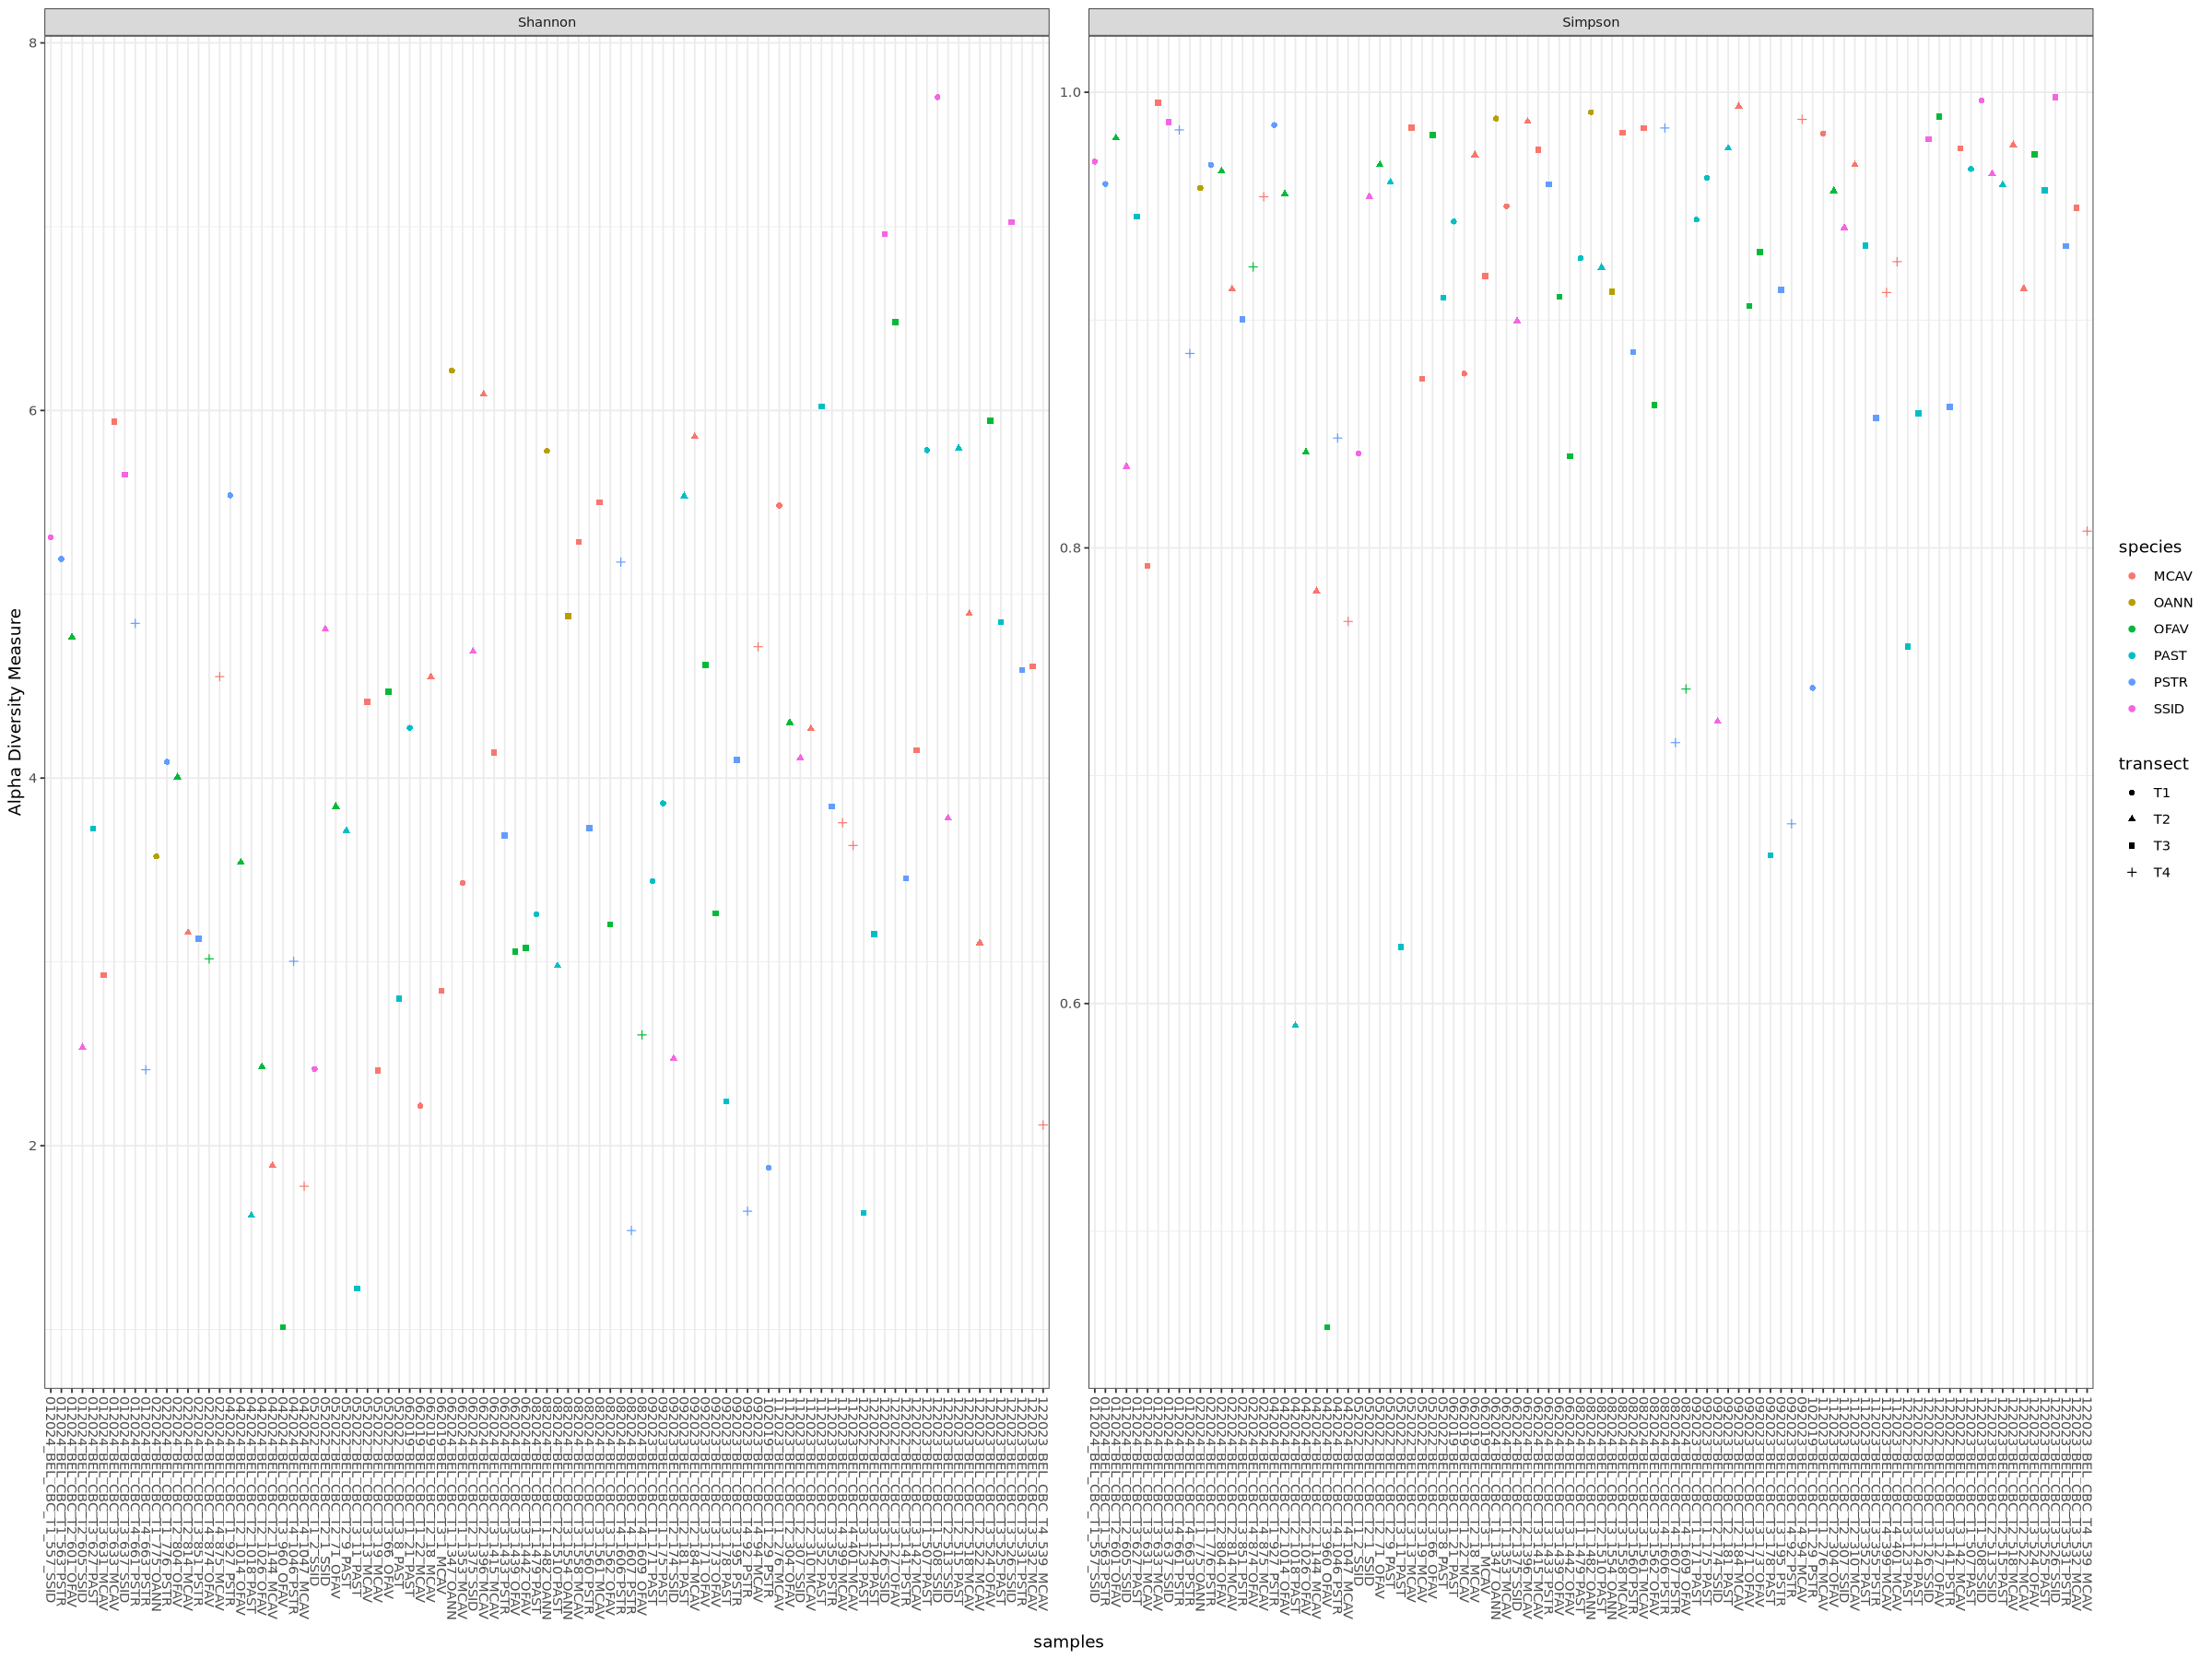

In [31]:
plot_richness(ps, measures=c("Shannon", "Simpson"), color="species", shape="transect")

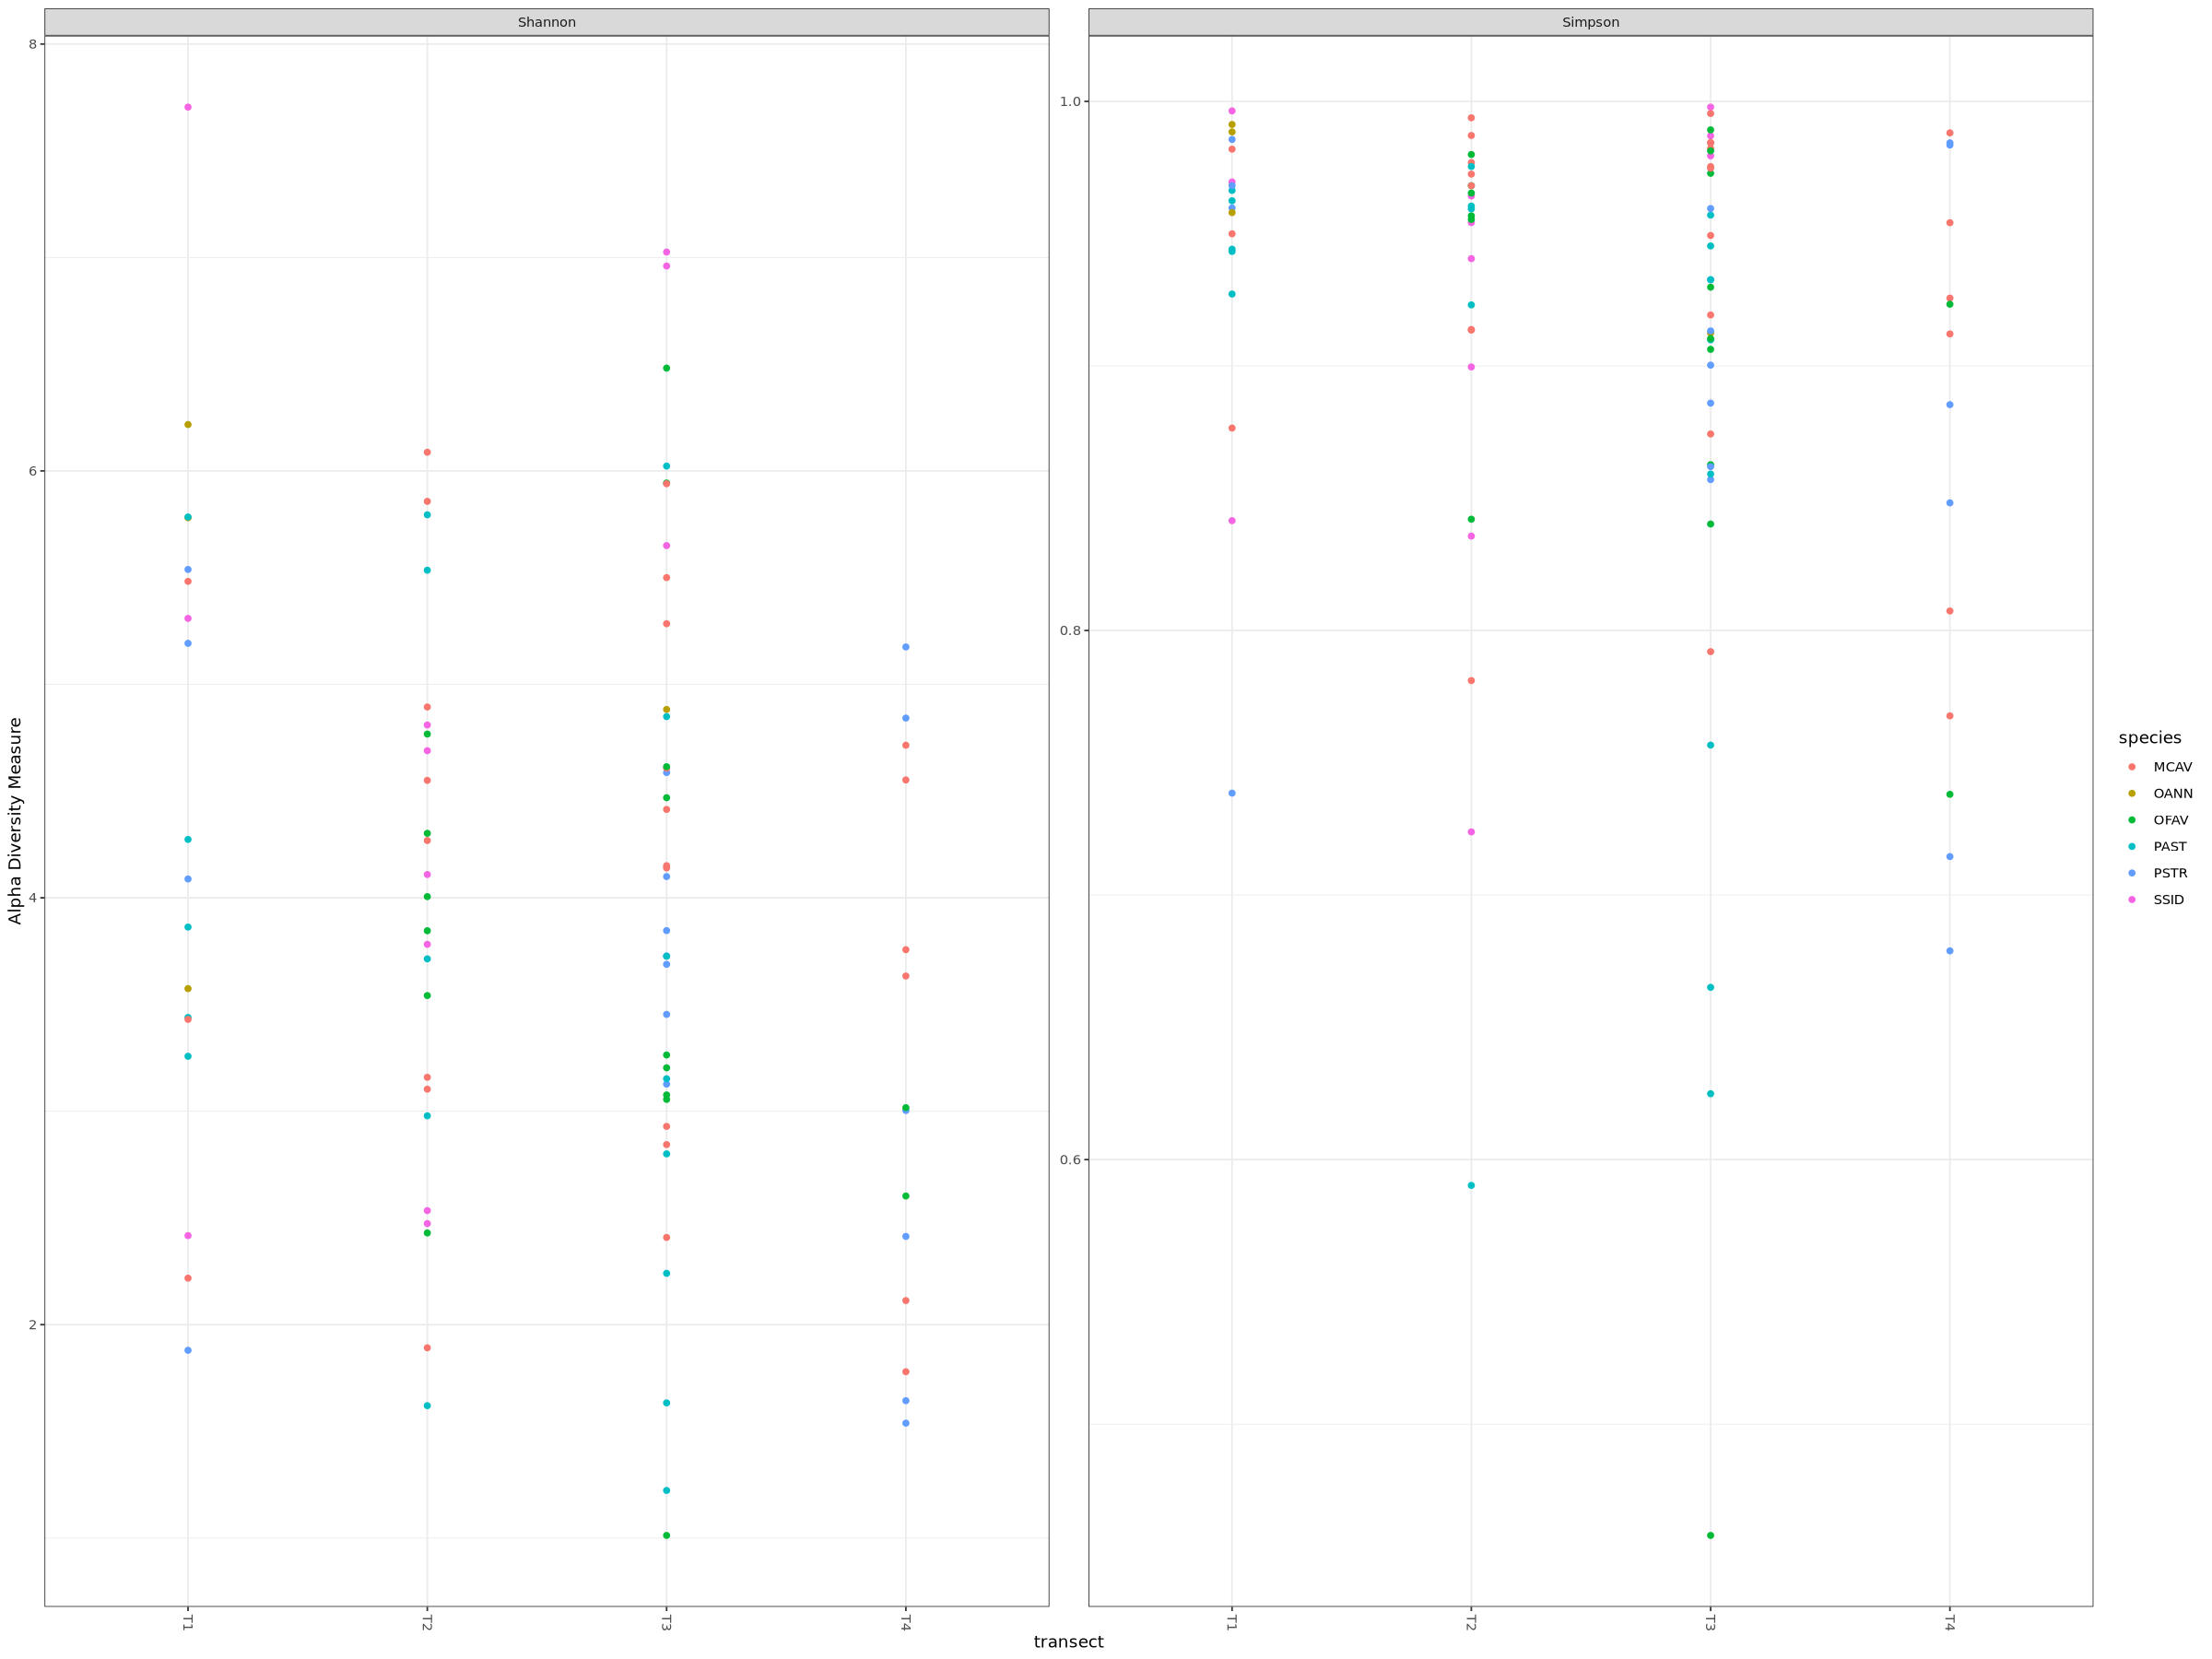

In [32]:
plot_richness(ps, x="transect", measures=c("Shannon", "Simpson"), color="species")

In [33]:
# Transform data to proportions as appropriate for Bray-Curtis distances
ps.prop <- transform_sample_counts(ps, function(otu) otu/sum(otu))
ord.nmds.bray <- ordinate(ps.prop, method="NMDS", distance="bray")

Run 0 stress 0.2308352 
Run 1 stress 0.2364084 
Run 2 stress 0.2359687 
Run 3 stress 0.2348377 
Run 4 stress 0.2508849 
Run 5 stress 0.2345088 
Run 6 stress 0.2346042 
Run 7 stress 0.2522619 
Run 8 stress 0.2393246 
Run 9 stress 0.2424962 
Run 10 stress 0.2354954 
Run 11 stress 0.2394333 
Run 12 stress 0.2377693 
Run 13 stress 0.2346654 
Run 14 stress 0.2384672 
Run 15 stress 0.2345091 
Run 16 stress 0.2338329 
Run 17 stress 0.2332691 
Run 18 stress 0.2562559 
Run 19 stress 0.2560023 
Run 20 stress 0.2610712 
*** Best solution was not repeated -- monoMDS stopping criteria:
    20: stress ratio > sratmax


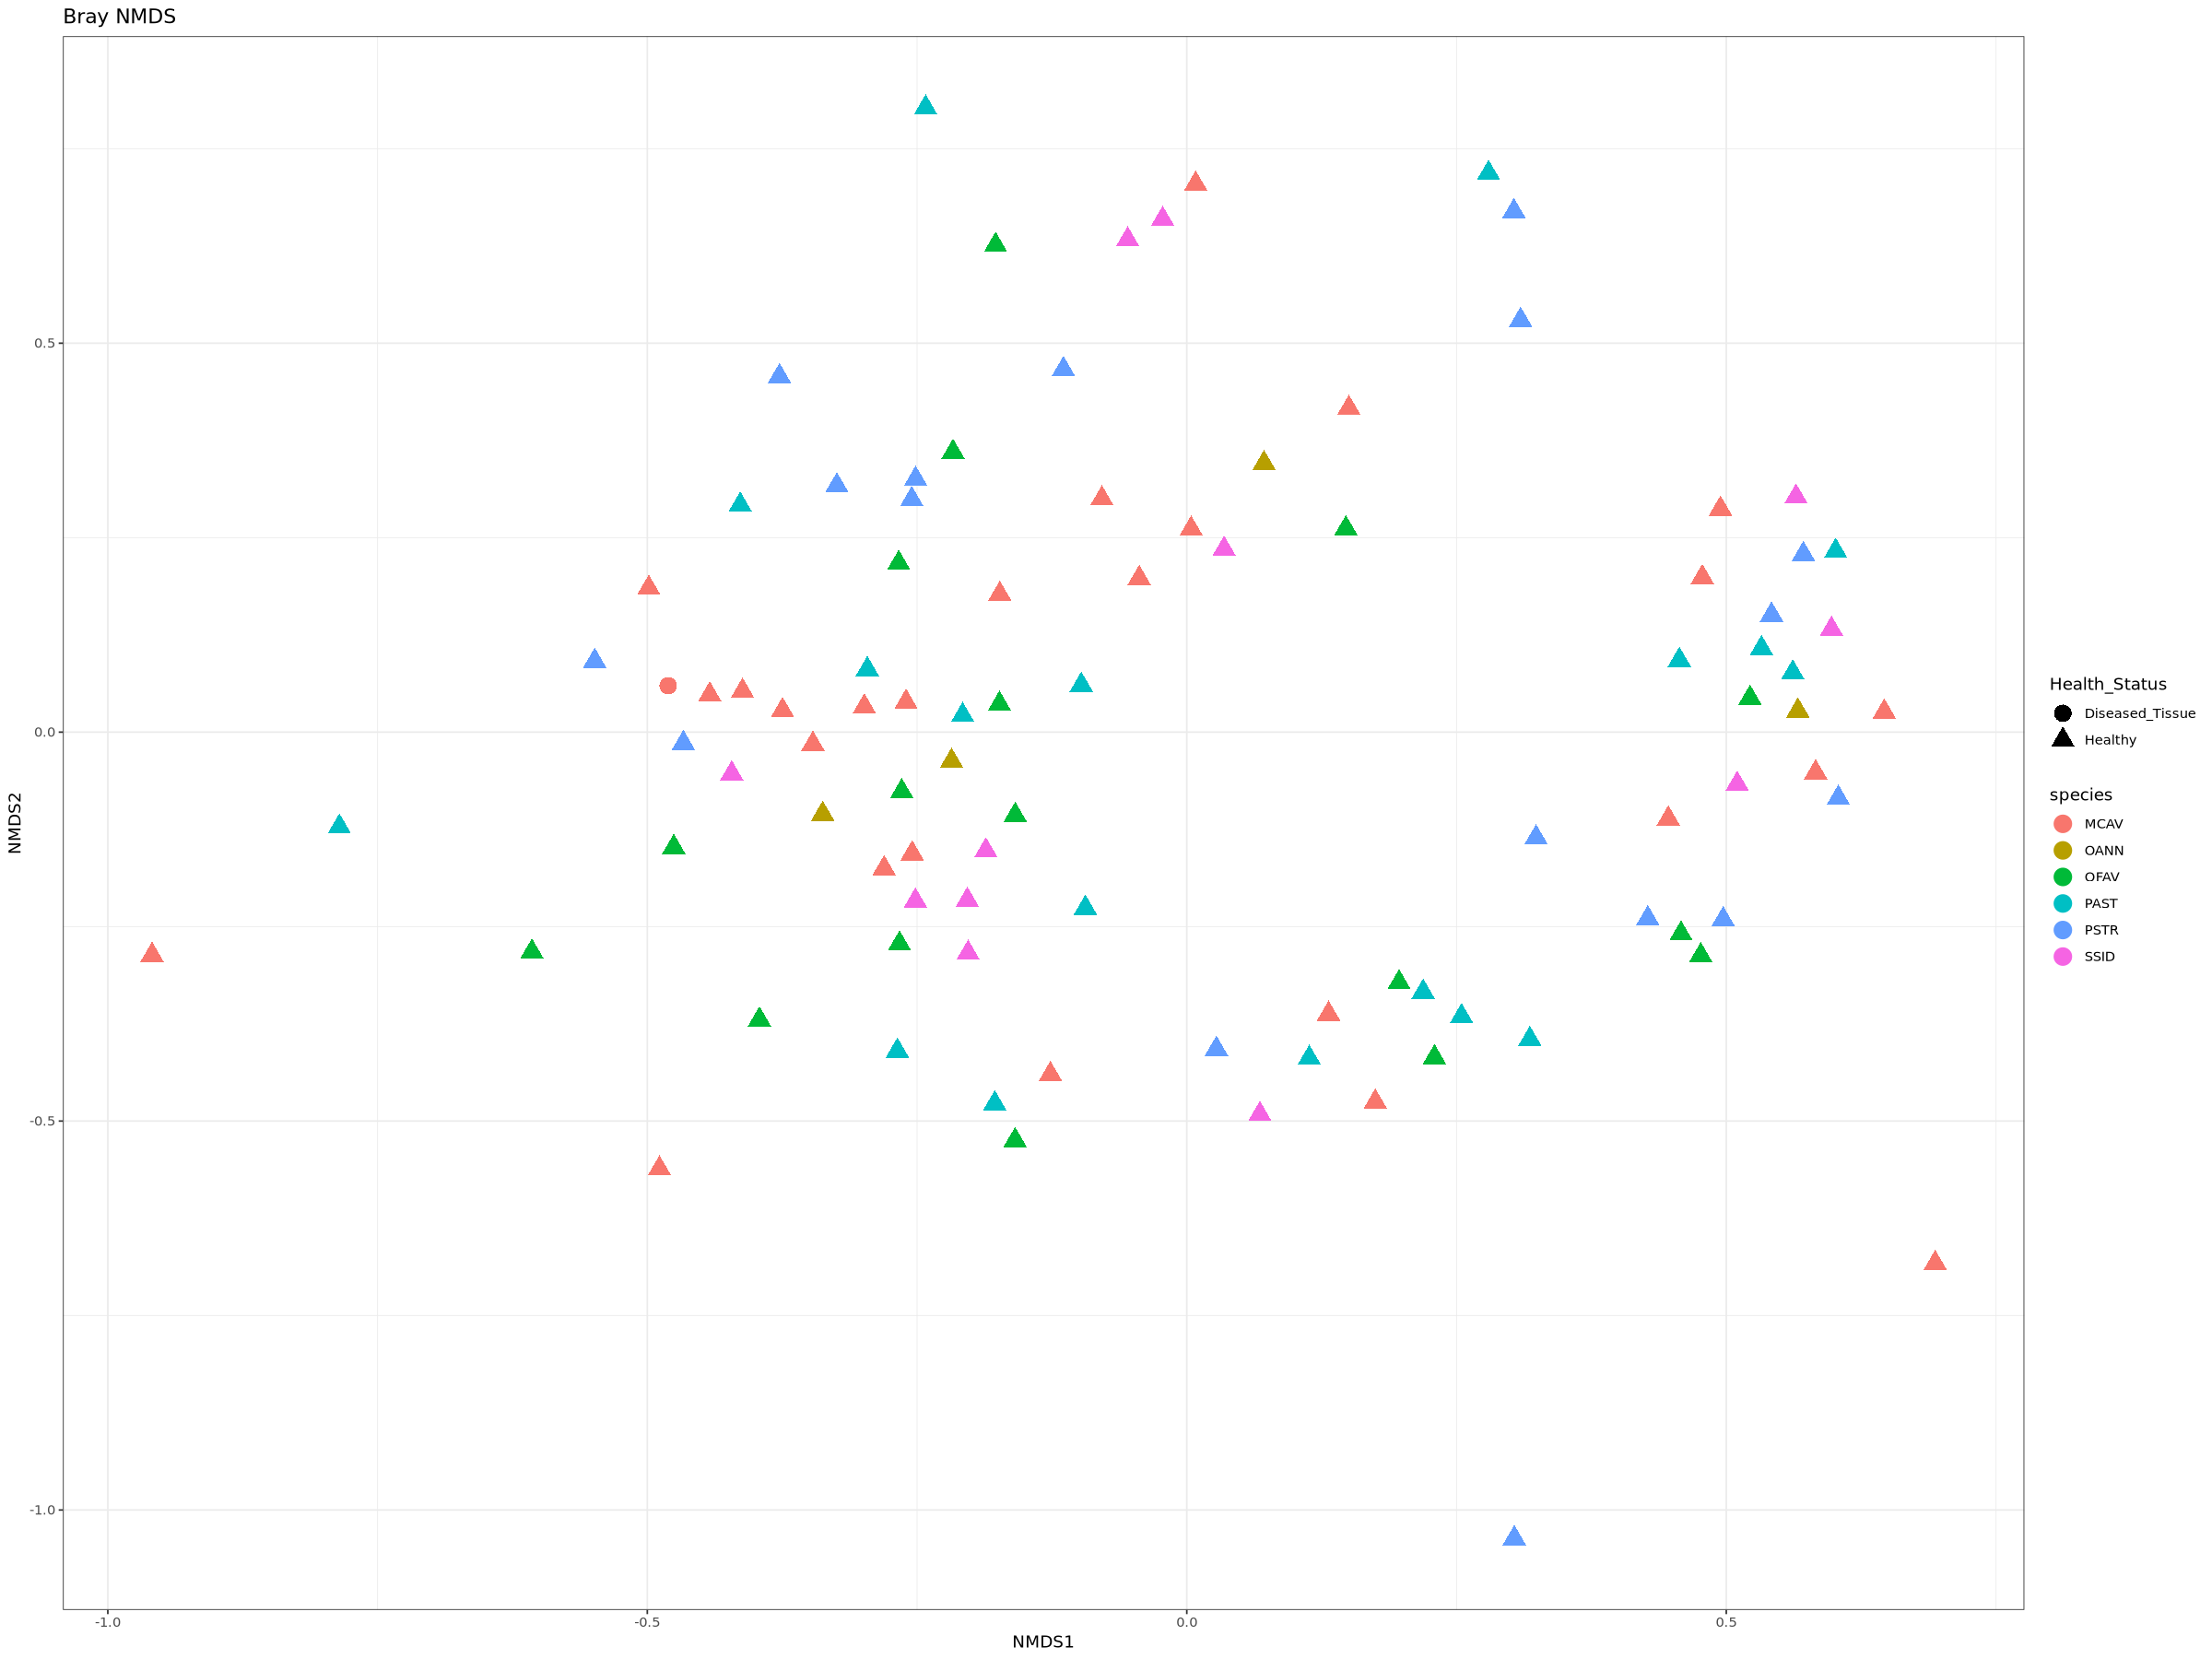

In [34]:
p=plot_ordination(ps.prop, ord.nmds.bray, color="species", shape="Health_Status", title="Bray NMDS" )
p+ geom_point(size=5)

#this has not been run yet bc led to Caused by error in `FUN()`: ! object 'Family' not found
top20 <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20]
ps.top20 <- transform_sample_counts(ps, function(OTU) OTU/sum(OTU))
ps.top20 <- prune_taxa(top20, ps.top20)
plot_bar(ps.top20, x="species", fill="Family") + facet_wrap(~transect, scales="free_x")

suppress wazrnings to not print all the warnings 

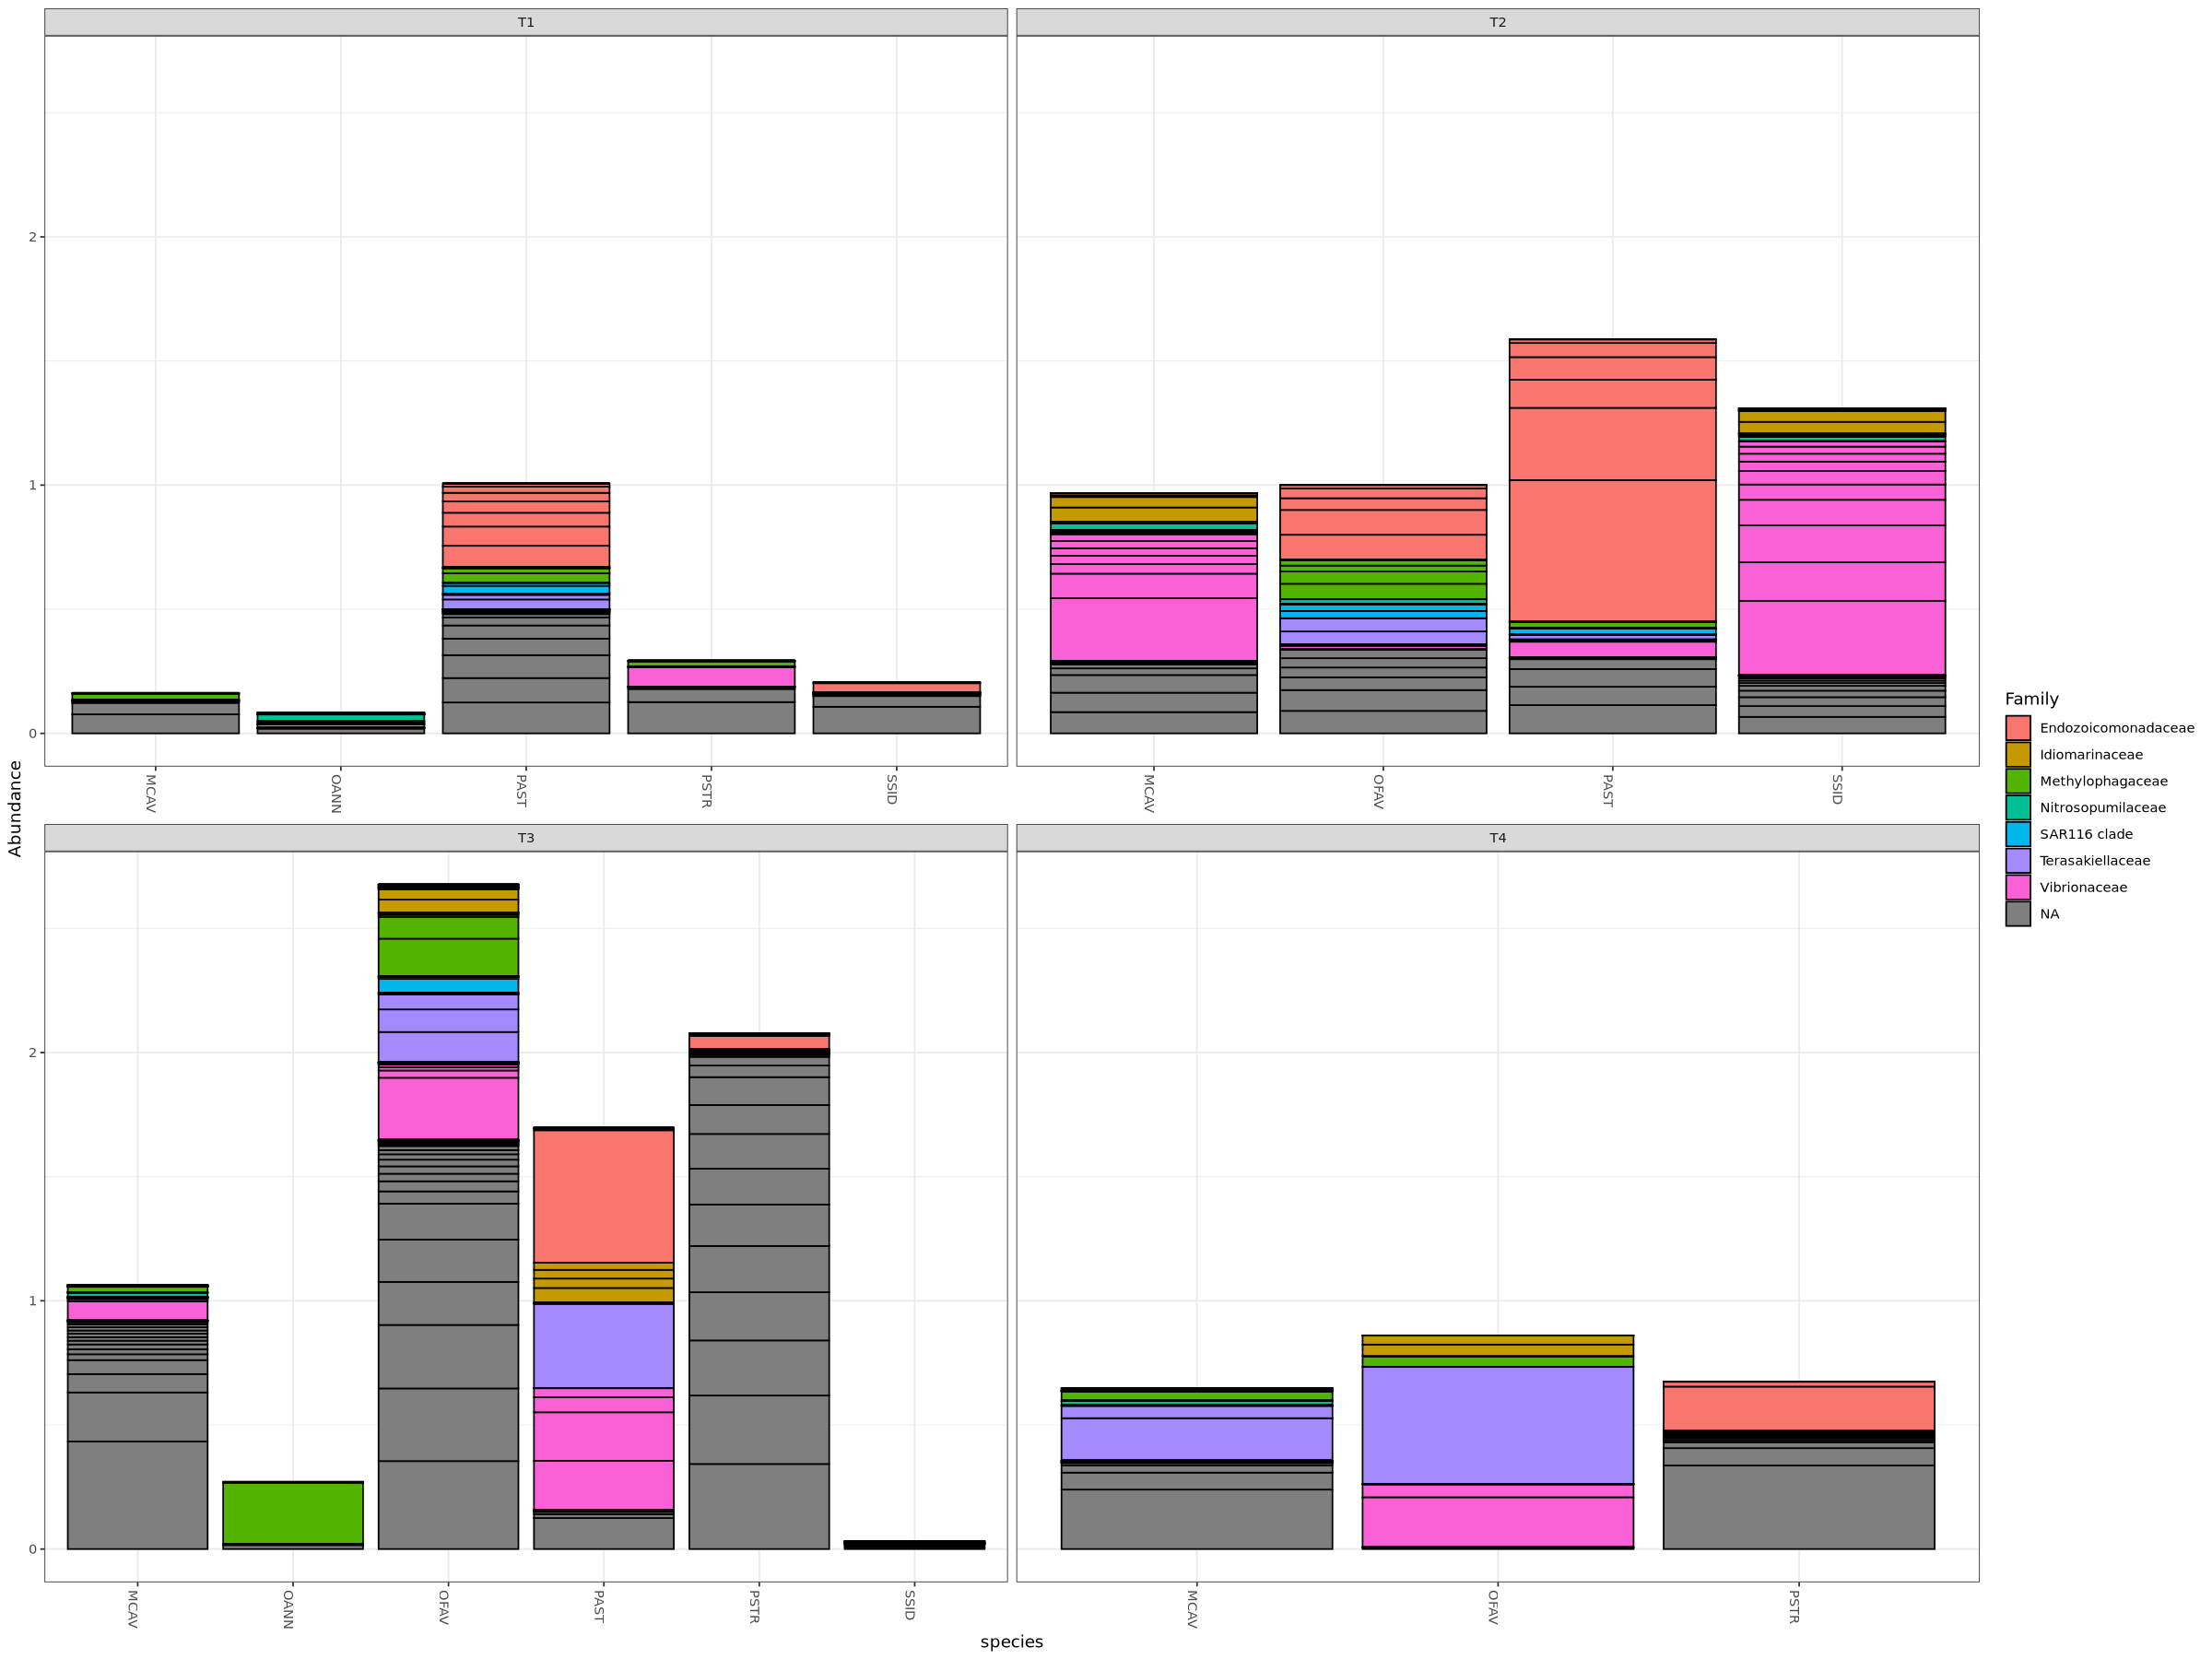

In [35]:
top20 <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20] 
ps.top20 <- transform_sample_counts(ps, function(OTU) OTU/sum(OTU)) 
ps.top20 <- prune_taxa(top20, ps.top20) 
plot_bar(ps.top20, x="species", fill="Family") + facet_wrap(~transect, scales="free_x")